# Leveraging the Jupyter and IPython display protocol

This is a small essay to show how one can make a better use of the display protocol. All you will see in this blog post has been available for a couple of years but noone really built on top of this. 

It is usually know that the IPython rich display mechanism allow libraries authors to define rich representation for 
their objects. You may have seen it in [SymPy](http://www.sympy.org/en/index.html), which make extensive use of the latex representation, and [Pandas](http://pandas.pydata.org/) which dataframes have nice HTML view. 

What I'm going to show below, is that one is not limited to these – you can alter the representation of any existing object without modifying its source – and that this can be used to alter the view of containers, with the example of lists, to make things easy to read. 

## Modifying objects reprs

This section is just a reminder of how one can change define representation for object which source code is under your 
control. When defining a class, the code author needs to define a number of methods which should return the `(data, metadata)` pair for a given object mimetype. If no metadata is necesary, these can be ommited. For some common representations short methods name ara availables. These methond can be recognized as they all follow the following pattern `_repr_*_(self)`. That is to say, an underscore, followed by `repr` followed by an underscore. The star `*` need to be replaced by a lowercase identifier often refering to a short human redable description of the format (e.g.: `png` , `html`, `pretty`, ...), ad finish by a single underscore. We note that unlike the python `__repr__` (pronouced "Dunder rep-er" which starts and ends wid two underscore, the "Rich reprs" or "Reprs-stars" start and end with a _single_ underscore.

Here is the class definition of a simple object that implements three of the rich representation methods:

  - "text/html" via the `_repr_html_` method
  - "text/latex" via the `_repr_latex_` method
  - "text/markdown" via the `_repr_markdown` method

None of these methonds return a tuple, thus IPython will infer that there is no metadata associated.
  
The "text/plain" mimetype representation is provided by the classical Python's `__repr__(self)`.

In [1]:
class MultiMime:
    
    def __repr__(self):
        return "this is the repr"
    
    def _repr_html_(self):
        return "This <b>is</b> html"
    
    def _repr_markdown_(self):
        return "This **is** mardown"

    def _repr_latex_(self):
        return "$ Latex \otimes mimetype $"

In [2]:
MultiMime()

this is the repr

All the mimetypes representation will be sent to the frontend (in many cases the notebook web interface), and the richer one will be picked and displayed to the the user. All representations are stored in the notebook document (on disk) and this can be choosen from when the document is later reopened – even with no kernel attached – or converted to another format. 

## External formatters and containers

As stated in teh introduction, you do not need to have control over an object source code to change its representation. Still it is often a more convenient process. AS an example we will build a Container for image thumbnails and see how we can use the code written for this custom container to apply it to generic Python containers like lists. 

As a visual example we'll use Orly Parody books covers, in particular a small resolution of some of them so llimit the amount of data we'll be working with. 

In [3]:
cd thumb

/Users/bussonniermatthias/dev/orly-full-res/thumb


let's see some of the images present in this folder:

In [4]:
names = !ls *.png
names[:20], f"{len(names) - 10} more"

(['10x-big.png',
  'adulting-big.png',
  'arbitraryforecasts-big.png',
  'avoiddarkpatterns-big.png',
  'blamingthearchitecture-big.png',
  'blamingtheuser-big.png',
  'breakingthebackbutton-big.png',
  'buzzwordfirst-big.png',
  'buzzwordfirstdesign-big.png',
  'casualsexism-big.png',
  'catchingemall-big.png',
  'changinstuff-big.png',
  'chasingdesignfads-big.png',
  'choosingbasedongithubstars-big.png',
  'codingontheweekend-big.png',
  'coffeeintocode-big.png',
  'copyingandpasting-big.png',
  'crushingit-big.png',
  'deletingcode-big.png',
  'doingwhateverdanabramovsays-big.png'],
 '63 more')

in the above i've used an IPython specific syntax (`!ls`) ton conveniently extract all the files with a png extension  (`*.png`) in the current working directory, and assign this to teh `names` variable.

That's cute, but, for images, not really usefull. We know we can display images in the Jupyter notebook when using the IPython kernel, for that we can use the `Image` class situated in the `IPython.display` submodule. We can construct such object simply by passing the filename. `Image` does already provide a rich representation:

In [5]:
from IPython.display import Image

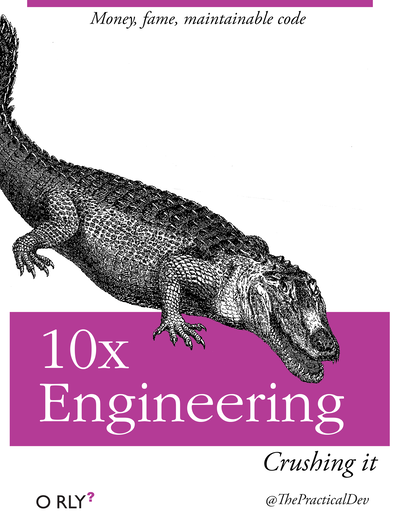

In [6]:
im = Image(names[0])
im

The raw data from the image file is available via the `.data` attribute:

In [7]:
im.data[:20]

b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\x90'

What if we map `Images` to each element of a list ?

In [8]:
from random import choices
mylist = list(map(Image, set(choices(names, k=10))))
mylist

[<IPython.core.display.Image object>,
 <IPython.core.display.Image object>,
 <IPython.core.display.Image object>,
 <IPython.core.display.Image object>,
 <IPython.core.display.Image object>,
 <IPython.core.display.Image object>,
 <IPython.core.display.Image object>,
 <IPython.core.display.Image object>,
 <IPython.core.display.Image object>,
 <IPython.core.display.Image object>]

Well unfortunately a list object only knows how to represent itself using text and the text representation of its elements. We'll have to build a thumbnail gallery ourself.

First let's (re)-build an HTML representation for display a single image:

In [9]:
import base64
from IPython.display import HTML
def tag_from_data(data, size='100%'):
    return (
        '''<img
             style="display:inline;
                    width:{1};
                    max-width:400px;
                    padding:10px;
                    margin-top:14px"
             src="data:image/png;base64,{0}"
           />
           ''').format(''.join(base64.encodebytes(data).decode().split('\n')), size)

We encode the data from bytes to base64 (newline separated), and strip the newlines. We format that into an Html template – with some inline style – and set the source (`src` to be this base64 encoded string). We can check that this display correctly by wrapping the all thing in an `HTML` object that provide a conveninent `_repr_html_`. 


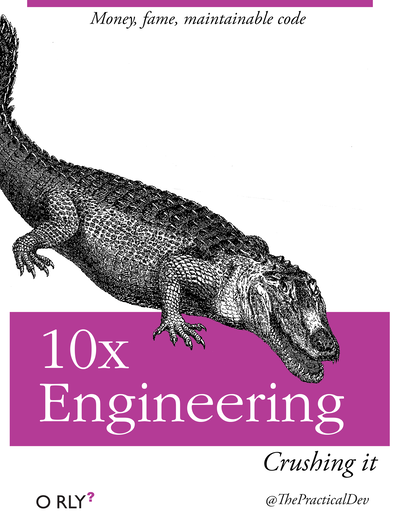

In [10]:
HTML(tag_from_data(im.data))

Now we can create our own subclass, hich take a list of images and contruct and HTML representation for each of these, then join them together. We define and define a `_repr_html_`, that wrap the all in a paragraph tag, and add a comma between each image: 

In [11]:
class VignetteList:
    
    
    def __init__(self, *images, size=None):
        self.images = images
        self.size = size
        
    def _repr_html_(self):
        return '<p>'+','.join(tag_from_data(im.data, self.size)  for im in self.images)+'</p>'
    
    def _repr_latex_(self):
        return '$ O^{rly}_{books} (%s\ images)$ ' % (len(self.images))
        

We also define a LaTeX Representation – that we will not use here, and look at our newly created object using previously defined list:


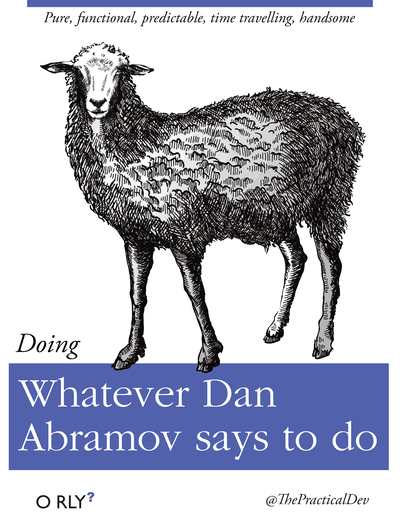
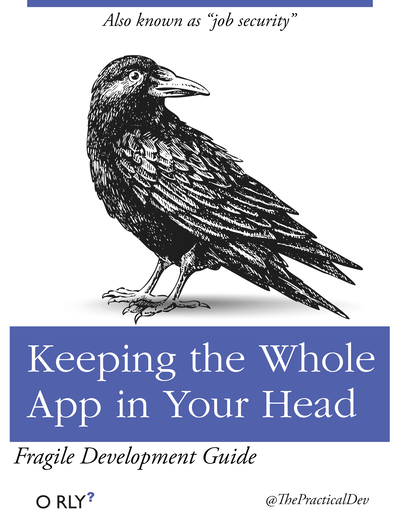
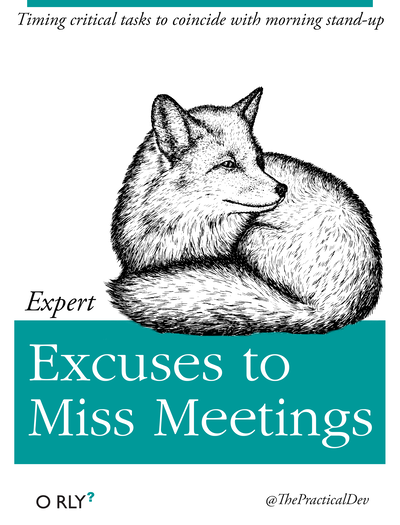
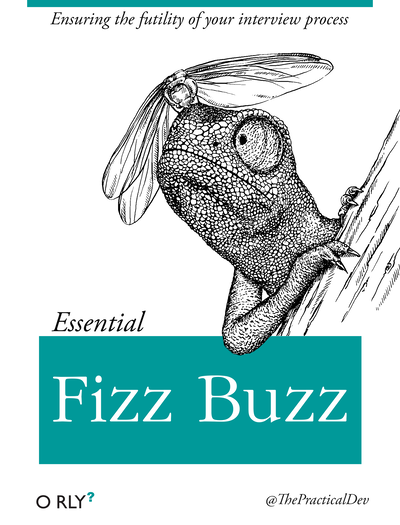
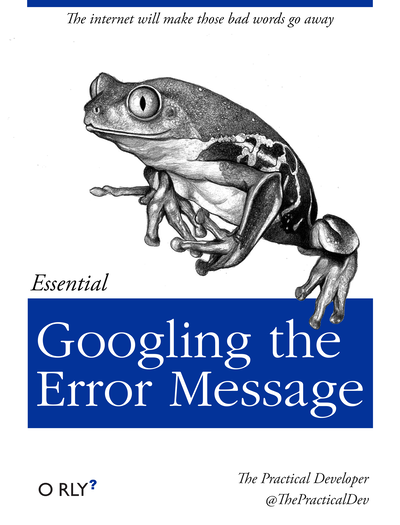
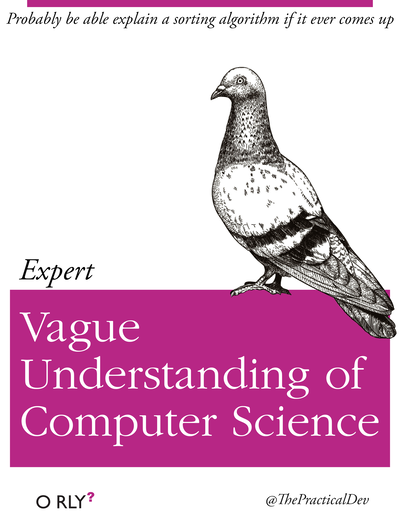
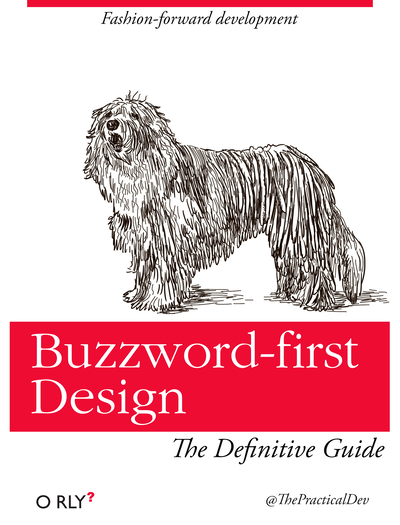
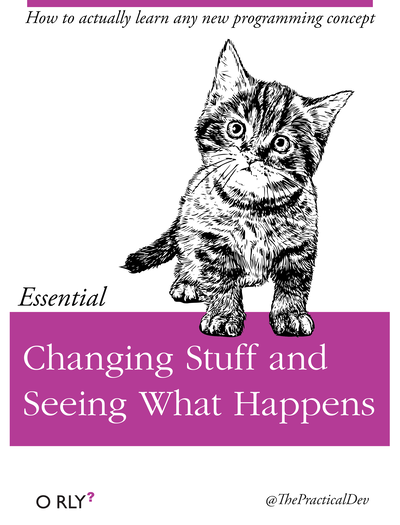
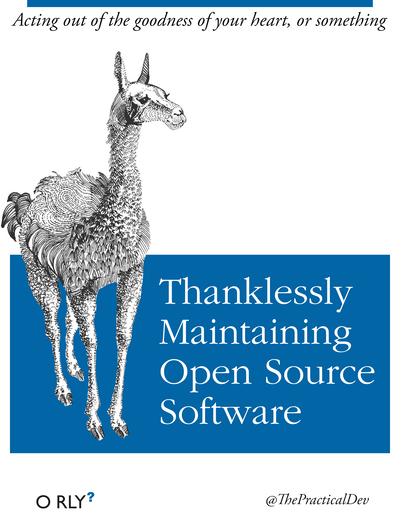
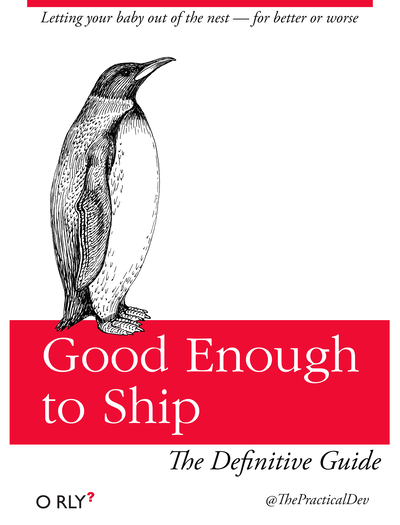

In [12]:
VignetteList(*mylist, size='200px')

That is nice, though it forces us to unpack all the lists we have explicitely into a VignetteList – which may be annoying. Let's cleanup a bit the above, and register an external formatter for the "text/html" mimetype that should be used for any object which is a `list`. We'll also improve the formatter to recusrse in objects. THat is to say: 
  - If it's an image return the PNG data in an `<img>` tag, 
  - If it's an object that has an `text/html` reprensetation, use that. 
  - Otherwise, use th repr. 
  
With this we loose some nice formatting of text lists with the pretty module, we could easily fix that; but we leve it as an exercice for the reader. 

In [13]:
def tag_from_data_II(data, size='100%'):
    return '''<img
                    style="
                        display:inline;
                        width:{1};
                        max-width:400px;
                        padding:10px;
                        margin-top:14px"
                    onMouseOver="this.style['box-shadow']='5px 5px 30px 0px rgba(163,163,163,1)'" 
                    onMouseOut="this.style['box-shadow']=''"
                    src="data:image/png;base64,{0}" 
             />'''.format(''.join(base64.encodebytes(data).decode().split('\n')), size)

def html_list_formatter(ll):
    html = get_ipython().display_formatter.formatters['text/html']
    reps = []
    for o in ll:
        if isinstance(o, Image):
            reps.append(tag_from_data_II(o.data, '200px') )
        else: 
            h = html(o)
            if h:    
                reps.append(h)
            else:
                reps.append(repr(o)+'')
    
    return '<span>['+','.join(reps)+']</span>'

Same as before, with square bracket after and before, and a bit of styling that change the drop shadow on hover. Now we register the above with IPython:

In [14]:
ipython = get_ipython()
html = ipython.display_formatter.formatters['text/html']
html.for_type(list, html_list_formatter)

[<IPython.core.display.Image object>,
 <IPython.core.display.Image object>,
 <IPython.core.display.Image object>,
 <IPython.core.display.Image object>,
 <IPython.core.display.Image object>,
 <IPython.core.display.Image object>,
 <IPython.core.display.Image object>,
 <IPython.core.display.Image object>,
 <IPython.core.display.Image object>,
 <IPython.core.display.Image object>]
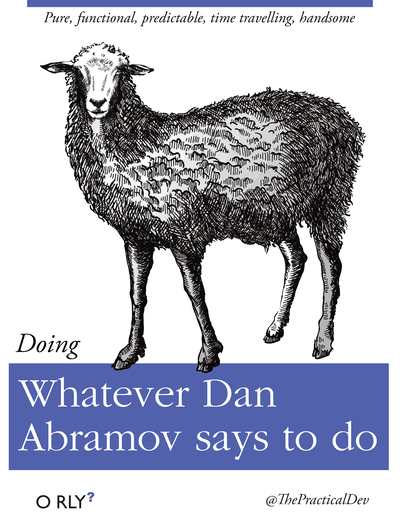
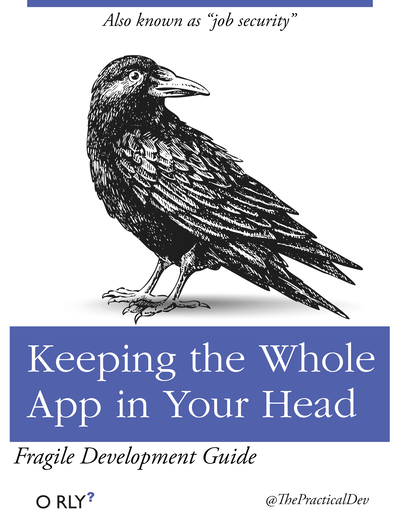
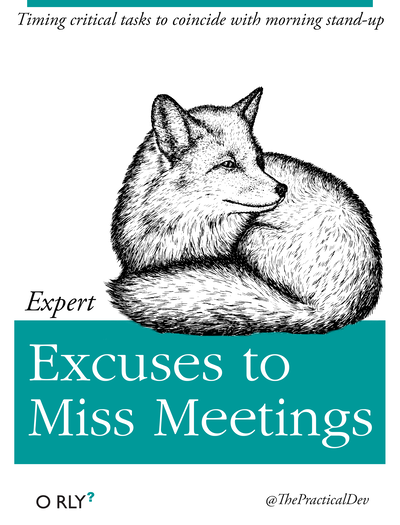
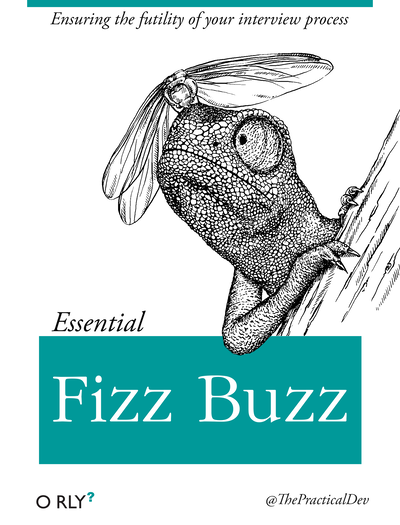
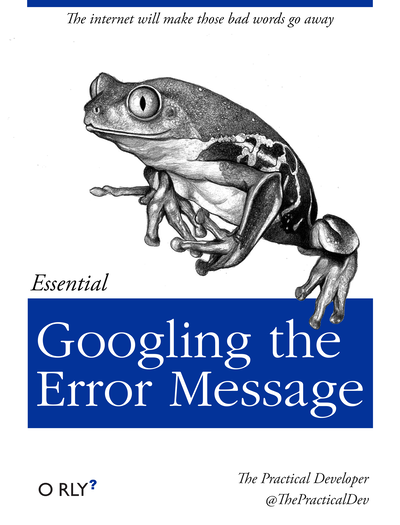
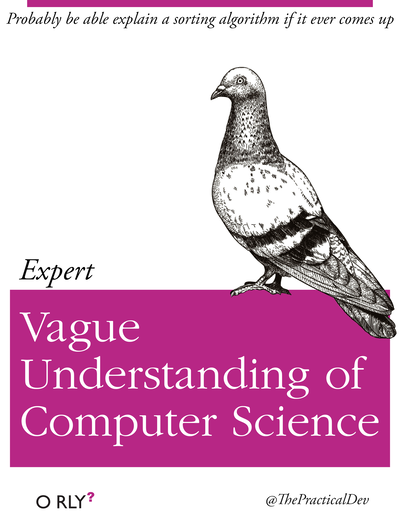
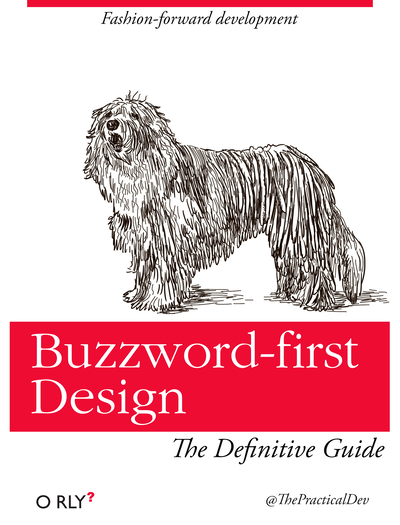
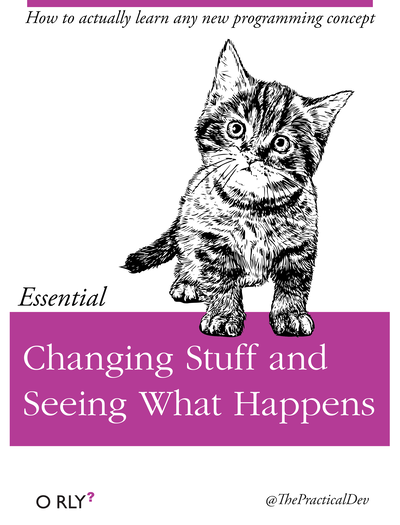
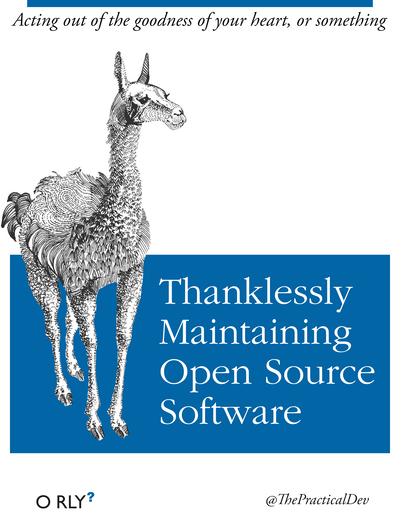
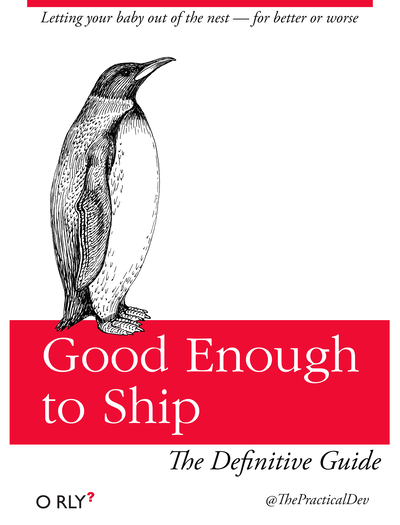

In [15]:
mylist

## Disp

External integration for some already existing object is available in [disp](https://github.com/ipython/disp), in particular you will find representation for SparkContext, `requests`'s `Responses` object (collapsible json content and headers), as well as a couple others. 

## Magic integration

The above demonstatratino show that a kernel is more than a language, it is a controling process that manage user requests (in our case code execution) and how the results are returned to the user. There is often the assumtion that a kernel is a single language, this is an incorrect assumtion as a kernl proces may manage several language and can orchestrate data movement from one language to another. 

In the following we can see how a Python process make use of what we have defined above to make sql querries returning rich results. We also see that the execution od SQL queries have side effects in the Python namespace, showing how the kernel can orchestrate things. 

In [16]:
cd ..

/Users/bussonniermatthias/dev/orly-full-res


In [17]:
load_ext fakesql

In [18]:
cd -

/Users/bussonniermatthias/dev/orly-full-res/thumb


In [19]:
try:
    rly
except NameError:
    print('`rly` not defined')

`rly` not defined


[<IPython.core.display.Image object>,
 <IPython.core.display.Image object>,
 <IPython.core.display.Image object>,
 <IPython.core.display.Image object>,
 <IPython.core.display.Image object>,
 <IPython.core.display.Image object>,
 <IPython.core.display.Image object>,
 <IPython.core.display.Image object>,
 <IPython.core.display.Image object>,
 <IPython.core.display.Image object>]
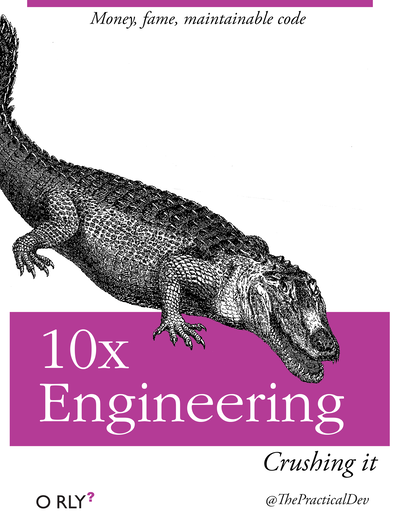
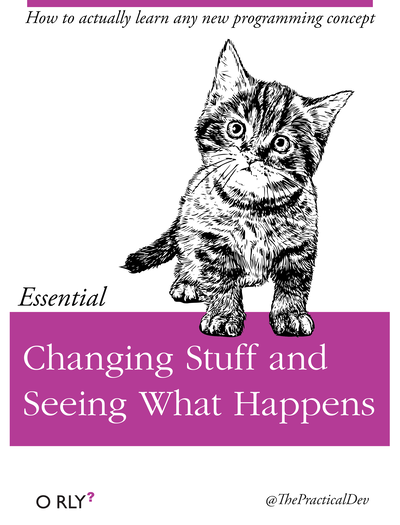
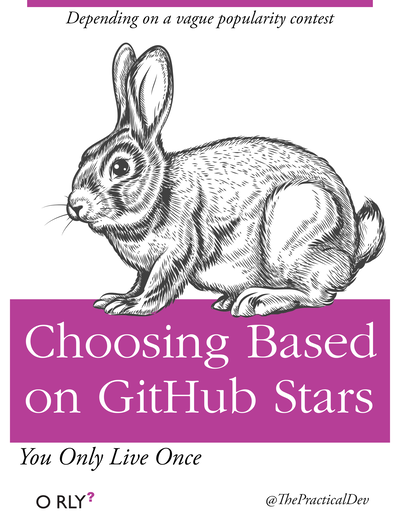
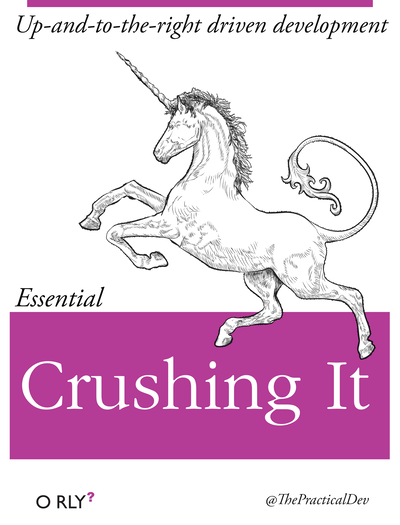
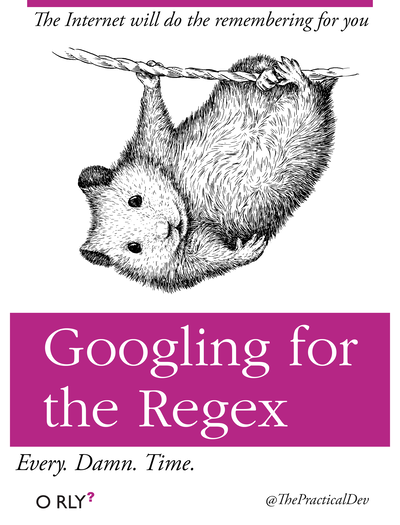
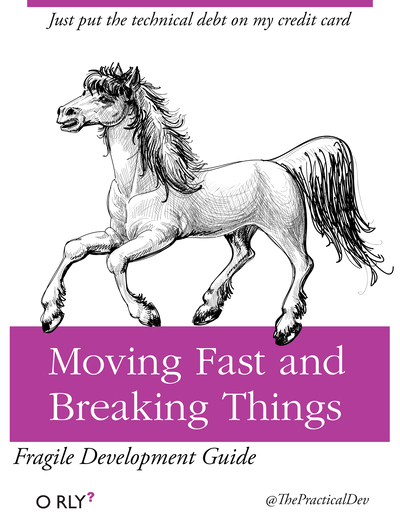
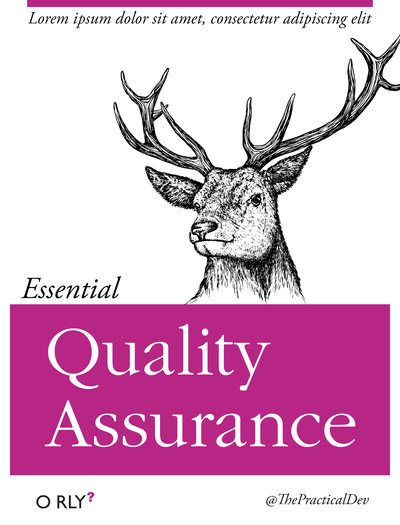
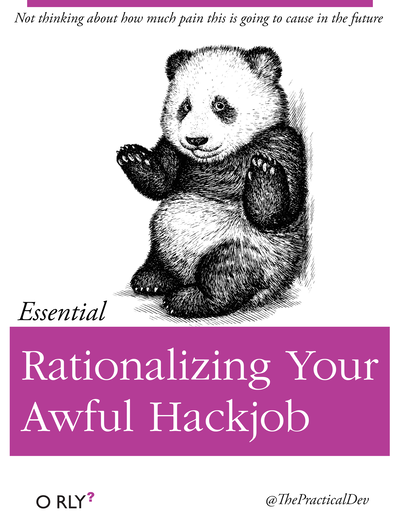
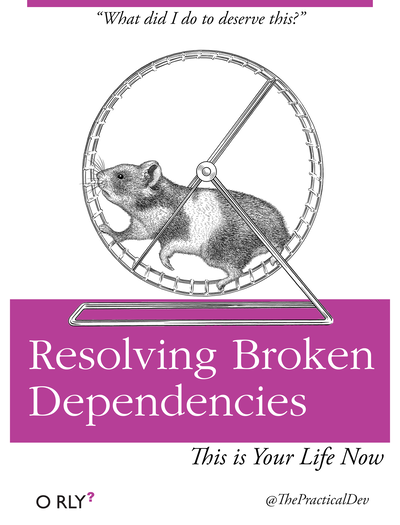
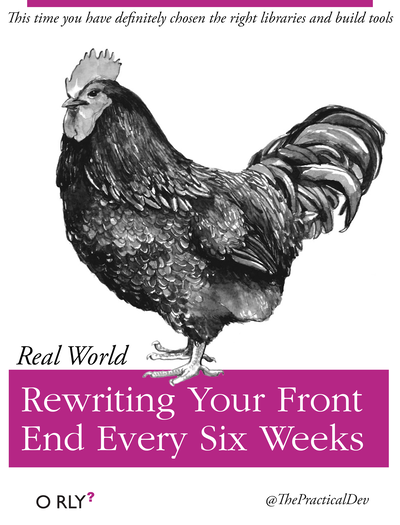

In [20]:
%%sql
SELECT cover from orly WHERE color='purple' LIMIT 10

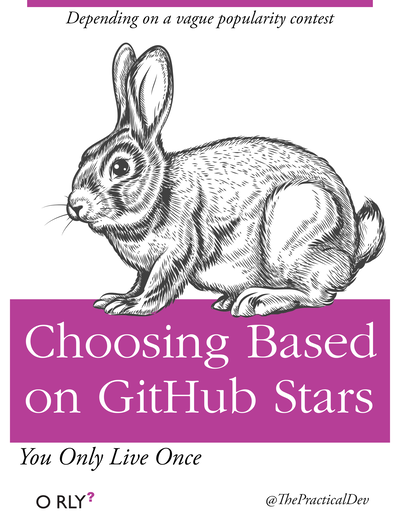

In [22]:
rly[2]

It would not be hard to have modification of the Python namespace to affect the SQL database, this is left as an exercise to the user as well (hint use properties) and to have integration with other languages like R, Julia, ... 

Note:

> This notebook has initially been written to display prototype features of IPython and the Jupyter notebook, in particular completions of cell magic (for the Sql Cell), and UI element allowing to switch between the shown mimetype. This will not be reflected in static rendering and is not mentioned in the text, which may lead to a confusing read. 